# Exploratory Data Analysis For Time Series Data - Data Science Interview
Source:
- [Time Series Forecasting with XGBoost - Use python and machine learning to predict energy consumption](https://www.youtube.com/watch?v=vV12dGe_Fho&ab_channel=RobMulla)
- [Time Series Forecasting with XGBoost - Advanced Methods](https://www.youtube.com/watch?v=z3ZnOW-S550&ab_channel=RobMulla)
- [Practical Time Series Analysis in R Book - Chapter 3]()
- [Time Series Analysis in Python – A Comprehensive Guide with Examples](https://www.machinelearningplus.com/time-series/time-series-analysis-python/)

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()

![](https://miro.medium.com/max/1400/1*V_RKPeIxCB9CS_2SsLyKXw.jpeg)

**Note**: There are different types of time series. If the data is purely random, there is no point of modeling at all. Sometimes, the data is stationary (not seasonal) or non-stationary (seasonal). Time series not usually fall into either bucket but will be a combination of two.

# Step 0: Import Data

In [2]:
df = pd.read_csv('../input/hourly-energy-consumption/PJME_hourly.csv')
df = df.set_index('Datetime')

# Step 1: Data Visualization

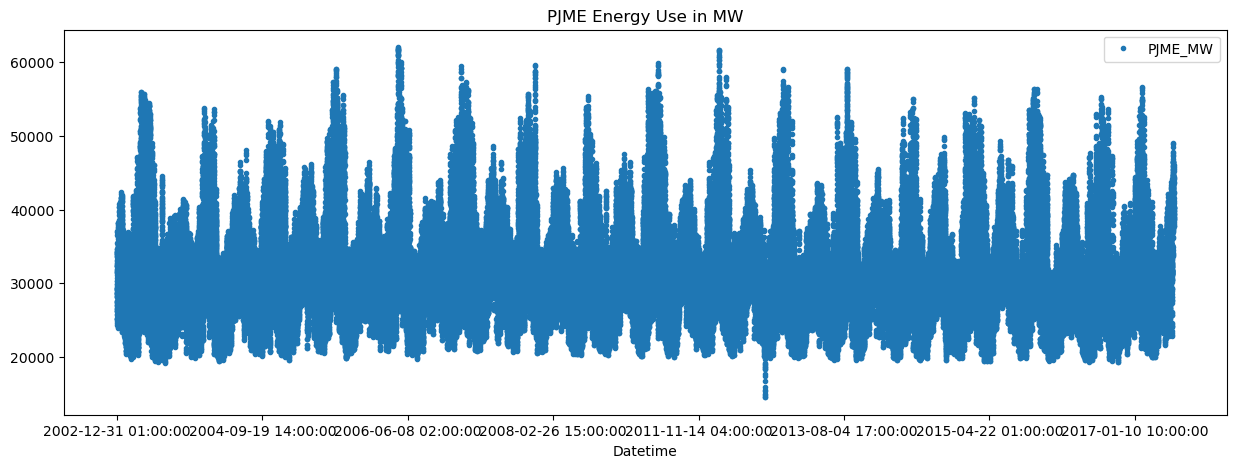

In [3]:
df.plot(style='.', figsize=(15,5), color=color_pal[0], title="PJME Energy Use in MW")
plt.show()

In [4]:
df.index

Index(['2002-12-31 01:00:00', '2002-12-31 02:00:00', '2002-12-31 03:00:00',
       '2002-12-31 04:00:00', '2002-12-31 05:00:00', '2002-12-31 06:00:00',
       '2002-12-31 07:00:00', '2002-12-31 08:00:00', '2002-12-31 09:00:00',
       '2002-12-31 10:00:00',
       ...
       '2018-01-01 15:00:00', '2018-01-01 16:00:00', '2018-01-01 17:00:00',
       '2018-01-01 18:00:00', '2018-01-01 19:00:00', '2018-01-01 20:00:00',
       '2018-01-01 21:00:00', '2018-01-01 22:00:00', '2018-01-01 23:00:00',
       '2018-01-02 00:00:00'],
      dtype='object', name='Datetime', length=145366)

In [5]:
# convert index to date time object
df.index = pd.to_datetime(df.index)

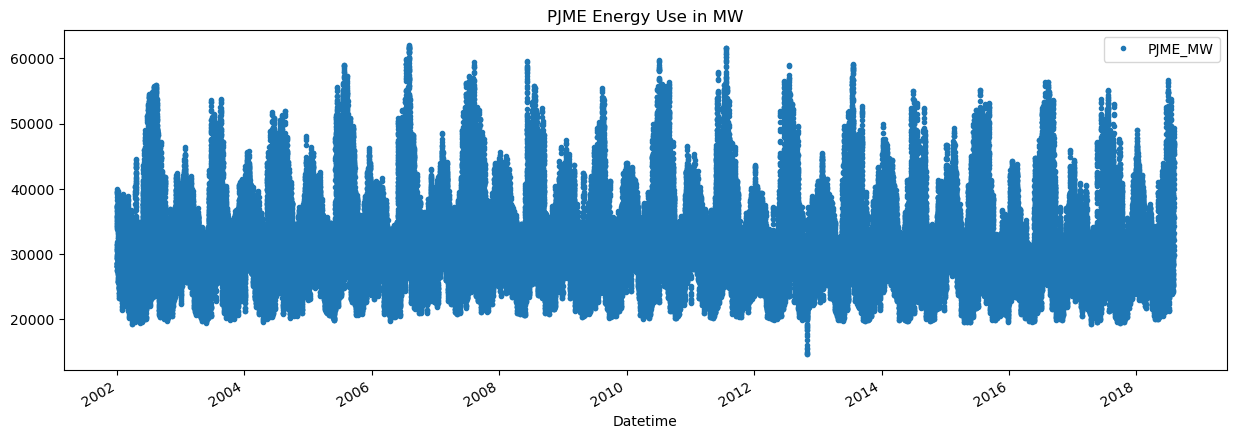

In [6]:
# re-plot it
df.plot(style='.', figsize=(15,5), color=color_pal[0], title="PJME Energy Use in MW")
plt.show()

# Step 2: Train Test Split
- For this notebook, we split the training data the time prior to 2015 to be training and everything after is testing data,

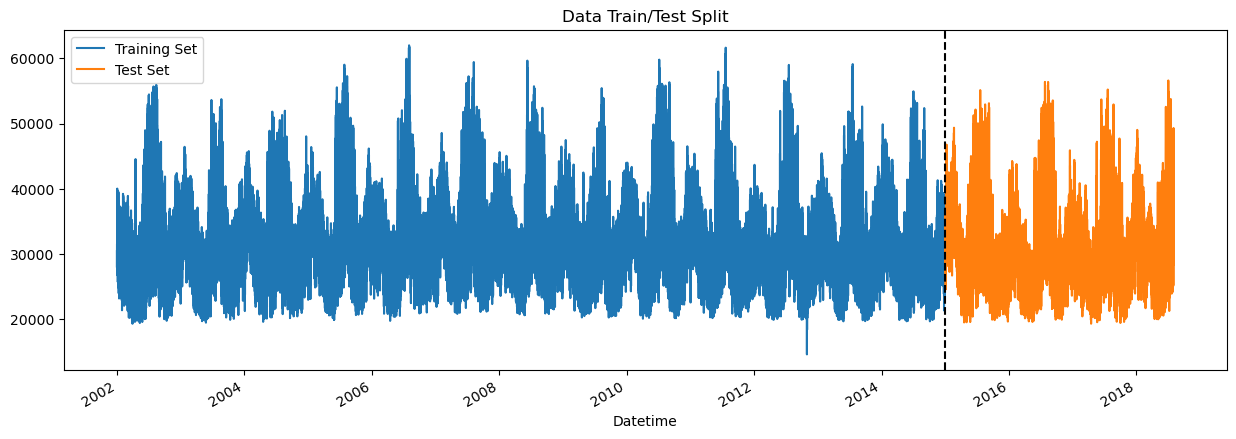

In [7]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

## Check a single week of data
- We can see that there are peaks during the days and drop during the nights.

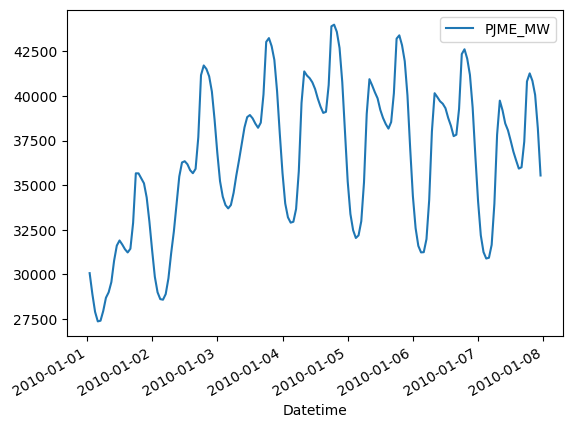

In [8]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot()
plt.show()

# Step 3: Feature Creation
From the index, we can create more features, We can extract:
- Hour
- Day of Week
- Quarter
- Month
- Year
- Day of Year

In [9]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [10]:
df = create_features(df)
df.head(5)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365


# Step 4: Feature Relationship & Visualization
- In tabular dataset, we use correlation matrix to check the relationship between features, thus combined with domain expert, we can create additional features. However, for time-series data, we can check relationship between features and labels. Thus, we can do feature selection.

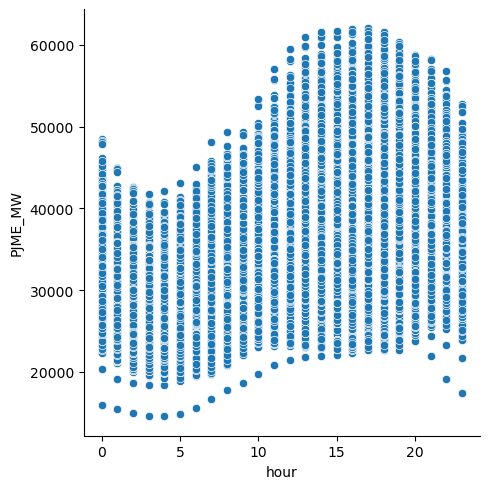

In [11]:
# scatter plot to show relationship between power in 24 hours
sns.relplot(data=df, x='hour', y='PJME_MW')
plt.show()

**Note**: scatter plot does not show the distribution of the data, let's use boxplot.

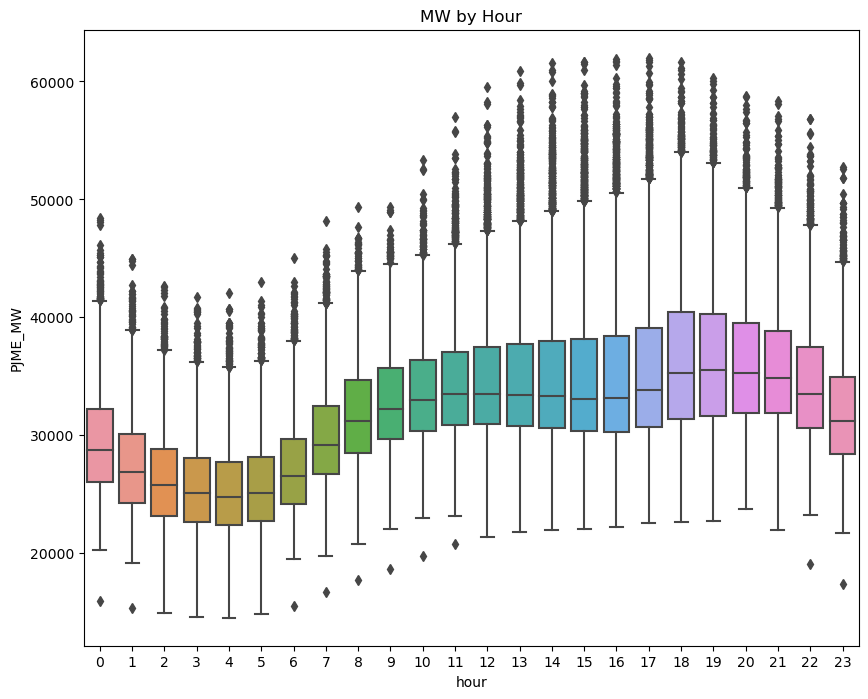

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

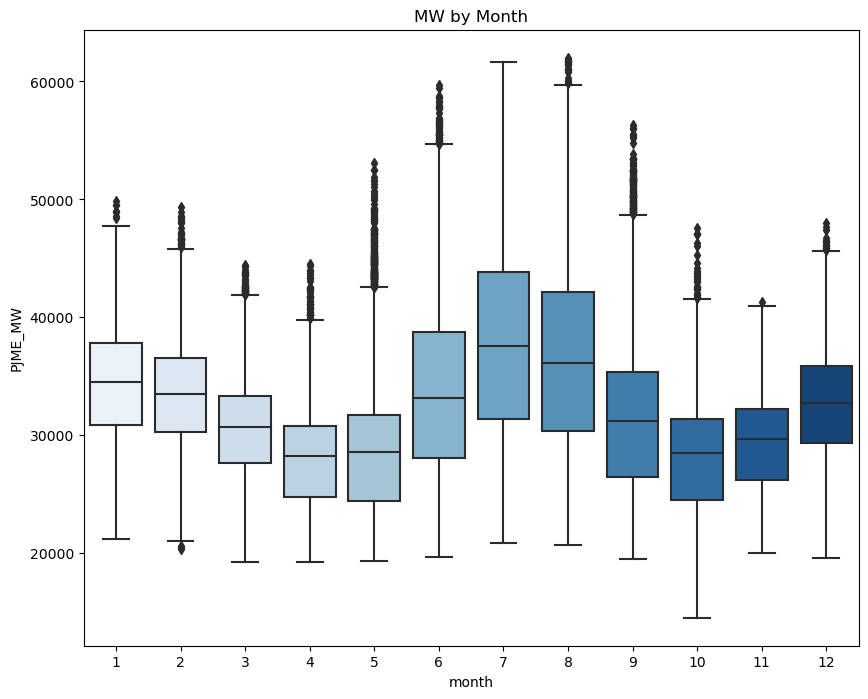

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette="Blues")
ax.set_title('MW by Month')
plt.show()

**Note**: we can see that the Power is peaked in thee Winter and Summer season compared to Spring and Fall.

How that we have some ideas about relationship between features and labels, We can create model.

# Step 5: Create Model
- Create a regression model.

In [14]:
train = create_features(train)
test = create_features(test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [15]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'PJME_MW'

In [16]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [17]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50,
                       learning_rate=0.01)
reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935
[100]	validation_0-rmse:12342.13873	validation_1-rmse:11517.66004
[200]	validation_0-rmse:5373.33346	validation_1-rmse:5165.30811
[300]	validation_0-rmse:3375.20923	validation_1-rmse:3829.25476
[400]	validation_0-rmse:2882.55200	validation_1-rmse:3715.04915
[437]	validation_0-rmse:2793.31200	validation_1-rmse:3727.16078


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

## Feature Importances
- This only happens for XGBoost

In [18]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

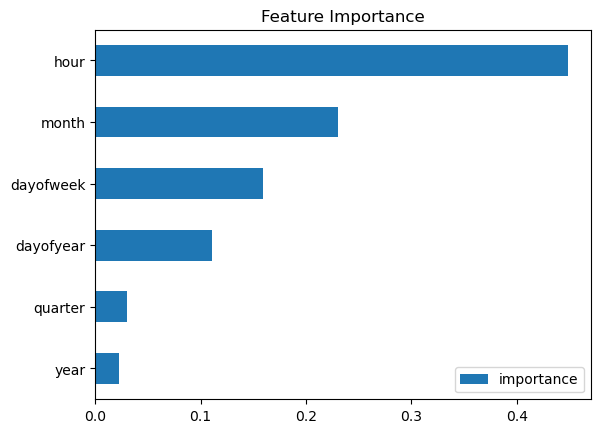

In [19]:
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Step 6: Forecast on Test Set

In [20]:
test['prediction'] = reg.predict(X_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,prediction
Datetime,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,NaN
...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,41014.218750
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,40507.140625
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,38933.621094


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


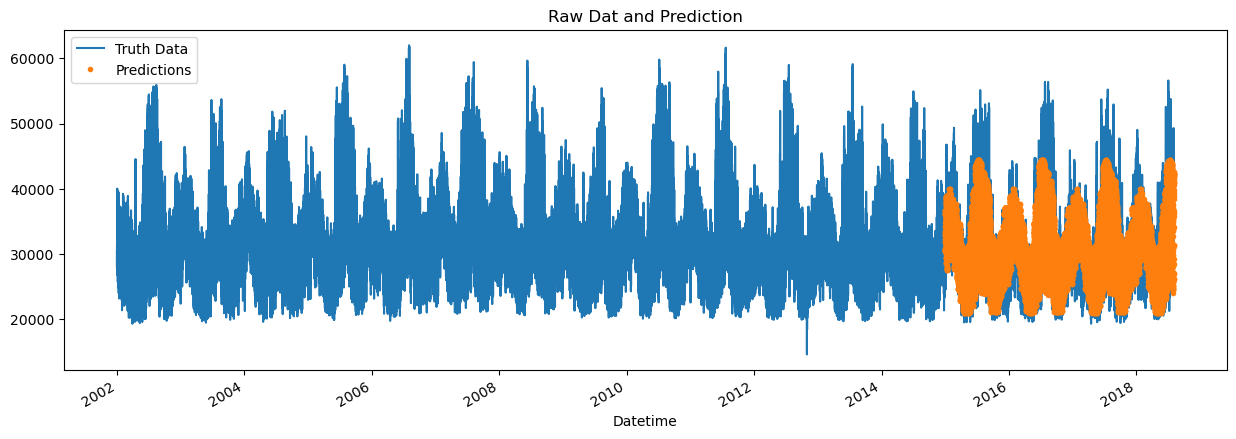

In [22]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

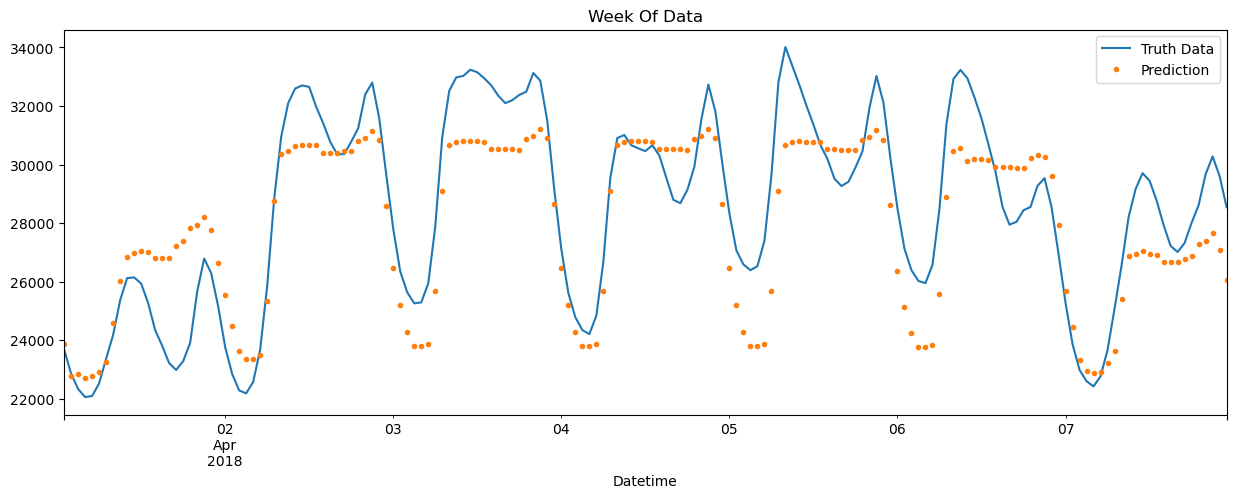

In [23]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

## Score RMSE
- The score is good compared to the validation performance (for regression task).

In [24]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3714.53


## Calculate Error
- Look at the worst and best predicted days

In [25]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    14559.813965
2016-08-14    14393.350911
2016-09-10    12564.790202
2016-08-12    11527.895264
2016-09-09    11432.962240
2018-01-06    10954.087728
2015-02-20    10897.302327
2016-08-11    10353.234131
2018-01-07    10226.969727
2017-05-19    10196.744385
Name: error, dtype: float64